# Определение стоимости автомобилей

## О проекте:


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Цель проекта:

    * Построить модель для определения стоимости

**Признаки**

    * DateCrawled — дата скачивания анкеты из базы
    * VehicleType — тип автомобильного кузова
    * RegistrationYear — год регистрации автомобиля
    * Gearbox — тип коробки передач
    * Power — мощность (л. с.)
    * Model — модель автомобиля
    * Kilometer — пробег (км)
    * RegistrationMonth — месяц регистрации автомобиля
    * FuelType — тип топлива
    * Brand — марка автомобиля
    * Repaired — была машина в ремонте или нет
    * DateCreated — дата создания анкеты
    * NumberOfPictures — количество фотографий автомобиля
    * PostalCode — почтовый индекс владельца анкеты (пользователя)
    * LastSeen — дата последней активности пользователя
    
**Целевой признак**

    * 
    Price — цена (евро)

## Подготовка данных

In [ ]:
import pandas as pd
import time
from IPython.display import Markdown, display
from tqdm.notebook import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import lightgbm as lgm
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

In [ ]:
def dataframe_info(df):
    
    ''' Вывод информации о датафрейме `df`. Функционал схож с методом `pd.DataFrame.info()`

    Дополнительно: вывод процента заполненных (non-null) значений, количестве дублей
    '''

    info = (pd.DataFrame({
                'notNA': df.count(), 'notNA, %': df.count()/df.shape[0]*100,
                'dtype': df.dtypes})
            .style.bar(subset='notNA, %', vmin=0, color='lightblue')
            .format("{:.2f}", subset=['notNA, %'])
    )
    print('DataFrame shape  : {} rows, {} columns'.format(df.shape[0], df.shape[1]))
    print('Memory usage     : {:.2f} MB'.format(df.memory_usage().sum()/1024/1024))
    print('Duplicates count :', df.duplicated().sum())
    return info

def show_hist(df, col, bins=100, xlim=None, ylim=None, figsize=None,
              title='Распределение значений',
              xlabel=None, ylabel='Количество значений'):
    '''
    Функция построения гистограмм и диаграмм размаха для столбца col датафрейма df
    
    Параметры 
    ---
    `bins` : int - задаёт число корзин для гистограммы, по умолчанию 100
    `title` : string - задаёт название графика
    `xlabel, ylabel` : string - подписи к осям
    `xlim, ylim, figsize` : параметры matplotlib 
    '''
    # создаём 3 сабплота, указываем для них соотношение занимаемой высоты
    _, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)

    if col in df.columns:
        # диаграмма размаха, гистограмма с функцией распределения
        sns.boxplot(x=df[col], ax=ax_box)
        sns.histplot(df[col], ax=ax_hist, bins=bins, kde=True)
        if xlabel is None: 
            xlabel = col
        ax_box.set(xlabel='')  # чтобы не дублировалась
        ax_hist.set(xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)
        ax_hist.grid(visible=True)
        plt.suptitle(title, y=0.92, fontsize=14)
    else:
        print('Столбец', col, 'отсутсвует в датафрейме')

def visualize_value_counts(df, column, n_values=25, fillna='NONE'):
    ''' Визуализация количества встречающихся значений столбца датафрейма

    `df` : pd.DataFrame - датафрейм
    `column` : string - название столбца
    `n_values` : int - максимальное количество значений для отображения на диаграмме
    `fillna` : any - значение, которым необходимо заполнить пропуски
    '''
    val_counts = df[column].fillna(fillna).value_counts()
    bar_values = val_counts.values[:n_values]
    bar_labels = val_counts.index[:n_values]
    plt.figure(figsize=(8, 0.35*min(len(val_counts), n_values)))
    ax = sns.barplot(x=bar_values, y=bar_labels)
    ax.set(title='"{}" value counts ({} / {})'
           .format(column, len(bar_labels), val_counts.shape[0]),
           xlim=[0, 1.1*bar_values.max()])
    plt.bar_label(ax.containers[0])
    for i in range(len(bar_labels)):
        if bar_labels[i] == fillna:
            ax.patches[i].set_color('black')
    plt.show()

In [ ]:
df = pd.read_csv('/datasets/autos.csv');df.columns = df.columns.str.lower();

display(df.sample(5))
display(dataframe_info(df))
display(df.describe())

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
286090,2016-03-30 12:50:01,3999,sedan,2002,manual,129,c_klasse,150000,9,petrol,mercedes_benz,no,2016-03-30 00:00:00,0,48249,2016-04-07 03:44:51
265954,2016-04-01 16:50:26,11200,small,2007,manual,174,cooper,125000,9,petrol,mini,no,2016-04-01 00:00:00,0,46483,2016-04-05 12:17:12
180981,2016-03-29 11:49:56,4850,wagon,2002,manual,116,3er,150000,6,gasoline,bmw,no,2016-03-29 00:00:00,0,74523,2016-04-05 21:15:26
333005,2016-03-07 18:46:07,850,small,2000,manual,60,fiesta,150000,7,petrol,ford,no,2016-03-07 00:00:00,0,22959,2016-03-15 01:17:39
301341,2016-03-14 01:54:41,4150,NaN,2016,manual,105,a3,150000,0,gasoline,audi,NaN,2016-03-13 00:00:00,0,23558,2016-04-07 06:15:52


DataFrame shape  : 354369 rows, 16 columns
Memory usage     : 43.26 MB
Duplicates count : 4


,notNA,"notNA, %",dtype
datecrawled,354369,100.00,object
price,354369,100.00,int64
vehicletype,316879,89.42,object
registrationyear,354369,100.00,int64
gearbox,334536,94.40,object
power,354369,100.00,int64
model,334664,94.44,object
kilometer,354369,100.00,int64
registrationmonth,354369,100.00,int64
fueltype,321474,90.72,object


,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
for col in ['numberofpictures', 'datecrawled', 'datecreated', 'lastseen']:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

print('Количество дублей', df.duplicated().sum())

Количество дублей 21333


In [ ]:
df = df.drop_duplicates(ignore_index=True)
df.shape

(333036, 12)

In [ ]:
if 'postalcode' in df.columns:
    df.drop('postalcode', axis=1, inplace=True)

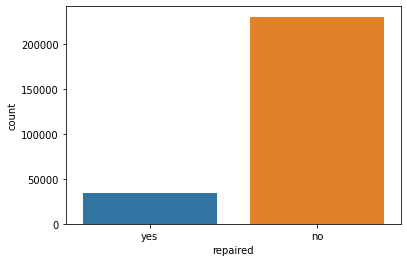

In [ ]:
sns.countplot(data=df, x='repaired');

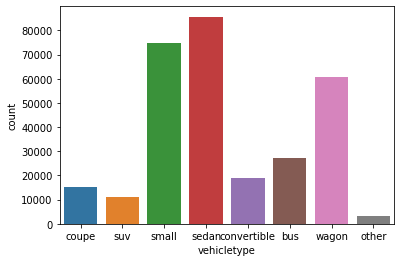

In [ ]:
sns.countplot(data=df, x='vehicletype');

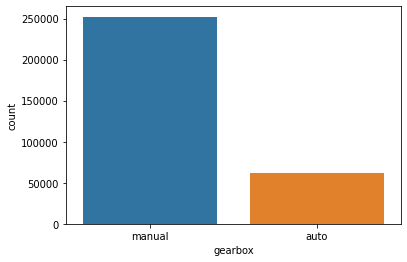

In [ ]:
sns.countplot(data=df, x='gearbox');

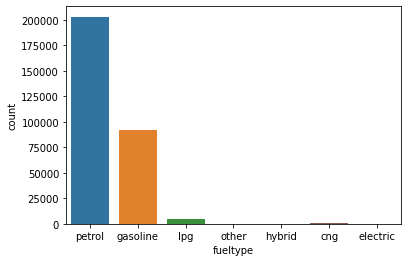

In [ ]:
sns.countplot(data=df, x='fueltype');

registrationyear < 1970 : 1309
registrationyear > 2016 : 13912


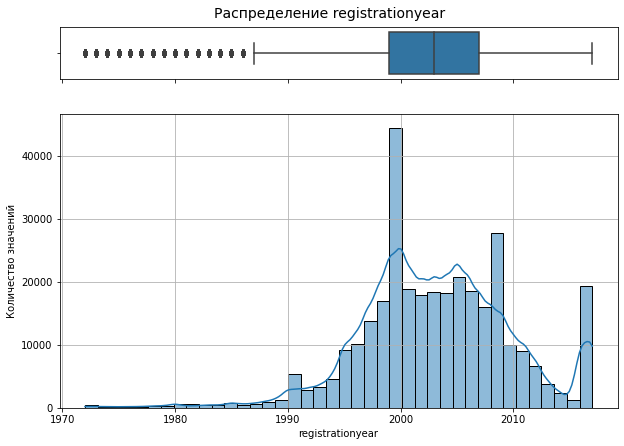

In [ ]:
f = 'registrationyear'
print(f+' < 1970 :', (df[f] < 1970).sum())
print(f+' > 2016 :', (df[f] > 2016).sum())

show_hist(df[(df[f] > df[f].quantile(.005)) & (df[f] < df[f].quantile(.995))],
          f, bins=40,  figsize=(10, 7), title='Распределение '+f)

In [ ]:
print('Аномальные значения :\n',
      df.query('registrationyear > 2016 or registrationyear < 1950')['registrationyear']
      .sort_values().unique())

Аномальные значения :
 [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 2017 2018 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500
 3700 3800 4000 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500
 7000 7100 7500 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


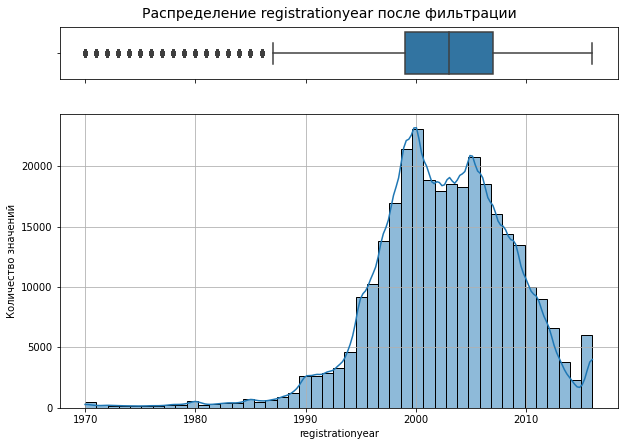

In [ ]:
df = df.query('1970 <= registrationyear <= 2016')
df = df.query('not (registrationyear == 2016 and registrationmonth > 4)')
show_hist(df, f, bins=45,  figsize=(10, 7), 
          title='Распределение '+f+' после фильтрации')

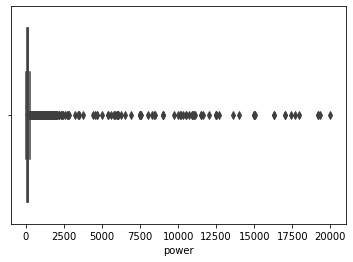

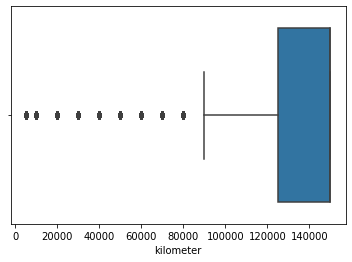

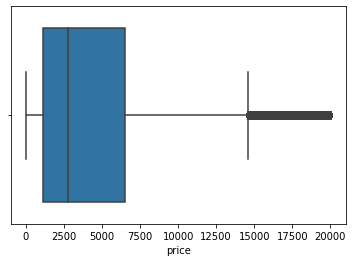

In [ ]:
for i in ['power', 'kilometer','price']:
    sns.boxplot(df[i]) 
    plt.show()

count    279275.000000
mean       2002.645228
std           6.151787
min        1970.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registrationyear, dtype: float64

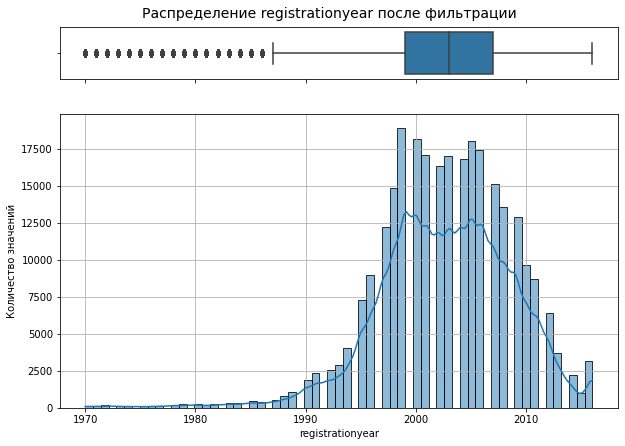

In [ ]:
df = df.query('10 <= power <= 500')
show_hist(df, f, bins=65,  figsize=(10, 7), title='Распределение '+f+' после фильтрации')
df[f].describe()

In [ ]:
print('Аномальные значения :\n',
      df.query('registrationmonth == 0 or registrationmonth > 12')['registrationmonth']
      .sort_values().unique())

Аномальные значения :
 [0]


14999.0

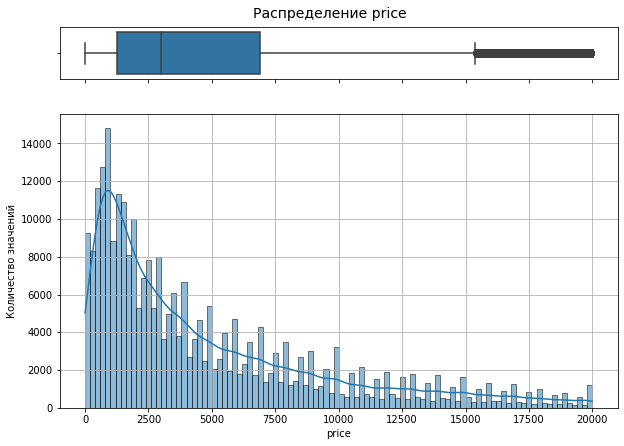

In [ ]:
f = 'price'
show_hist(df, f, bins=100,  figsize=(10, 7), title='Распределение '+f)
df[f].quantile(0.95)

count    258912.000000
mean       4189.916771
std        3674.863273
min         100.000000
25%        1290.000000
50%        2950.000000
75%        6200.000000
max       14999.000000
Name: price, dtype: float64

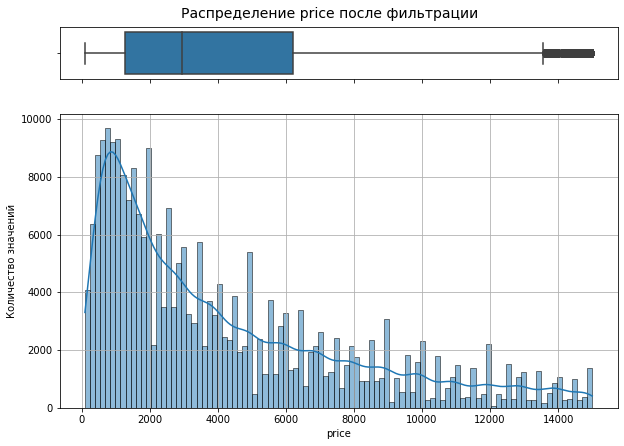

In [ ]:
df = df.query('100 <= price < 15000')
show_hist(df, f, bins=100, figsize=(10, 7), title='Распределение '+f+' после фильтрации')
df[f].describe()

In [ ]:
if 'registrationmonth' in df.columns:
    df.drop('registrationmonth', axis=1, inplace=True)

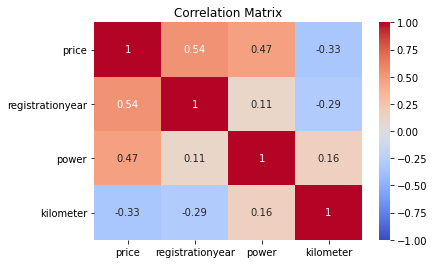

DataFrame shape  : 258912 rows, 10 columns
Memory usage     : 19.75 MB
Duplicates count : 19930


,notNA,"notNA, %",dtype
price,258912,100.00,int64
vehicletype,251743,97.23,object
registrationyear,258912,100.00,int64
gearbox,254047,98.12,object
power,258912,100.00,int64
model,249287,96.28,object
kilometer,258912,100.00,int64
fueltype,245638,94.87,object
brand,258912,100.00,object
repaired,220312,85.09,object


In [ ]:
df = df.reset_index(drop=True)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
dataframe_info(df)

**Вывод:** хорошая корреляция у цены и года регистранции авто, дубликаты появляются из за схожих месяцев и годов

`vehicletype`, unique values: 8
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']



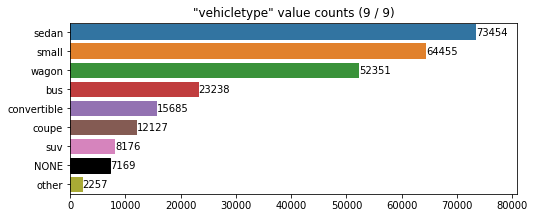

`gearbox`, unique values: 2
['auto', 'manual']



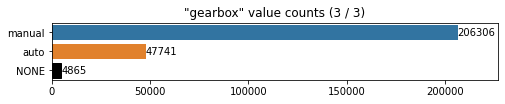

`model`, unique values: 249
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fo

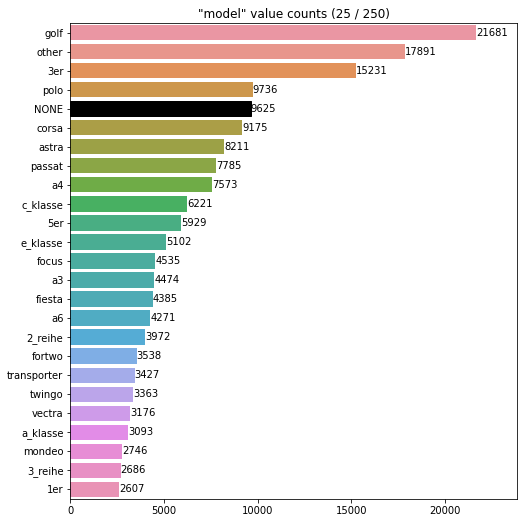

`fueltype`, unique values: 7
['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']



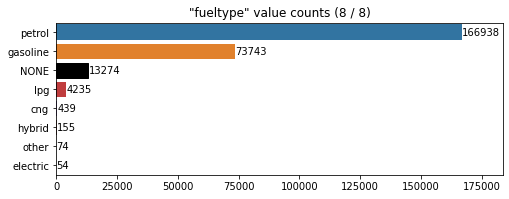

`brand`, unique values: 40
['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']



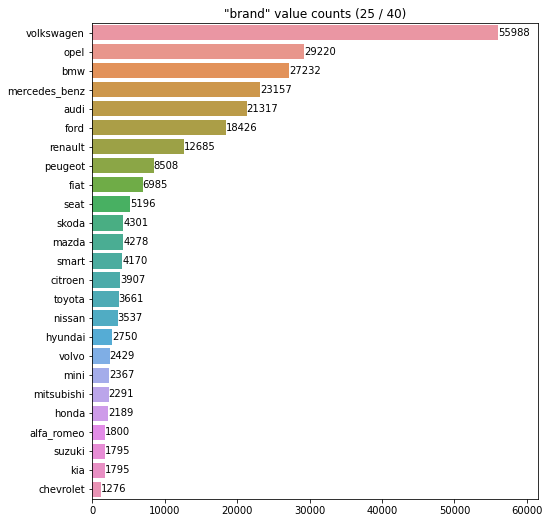

`repaired`, unique values: 2
['no', 'yes']



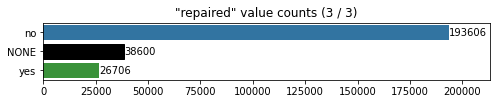

In [ ]:
int_features = list(df.select_dtypes('integer').columns)
cat_features = list(df.select_dtypes('object').columns)
for f in cat_features:
    _ = df[f].dropna().unique()
    print('`{}`, unique values: {}\n{}\n'
          .format(f, len(_), sorted(_)))
    visualize_value_counts(df, f)

In [ ]:
df['vehicletype'] = df['vehicletype'].fillna('other')
df['gearbox'] = df['gearbox'].fillna(df['gearbox'].mode()[0])
df['model'] = df['model'].fillna('unknown')
df['fueltype'] = df['fueltype'].fillna('petrol')
df['brand'] = df['brand'].fillna('unknown')
df['repaired'] = df['repaired'].fillna('no')

In [ ]:
df[int_features] = df[int_features].apply(pd.to_numeric, downcast='integer')
df[cat_features] = df[cat_features].astype('category')

dataframe_info(df)

DataFrame shape  : 258912 rows, 10 columns
Memory usage     : 4.21 MB
Duplicates count : 28317


,notNA,"notNA, %",dtype
price,258912,100.00,int16
vehicletype,258912,100.00,category
registrationyear,258912,100.00,int16
gearbox,258912,100.00,category
power,258912,100.00,int16
model,258912,100.00,category
kilometer,258912,100.00,int32
fueltype,258912,100.00,category
brand,258912,100.00,category
repaired,258912,100.00,category


**Вывод:** от лишних признаков не влияющих на score избавились, заполнили все пропуски и убрали дубликаты. Данные полностью готовы к обучению на моделях

<div class="alert alert-block alert-info">
<b>Ответ[2]:</b>
    
- `катбуст отвалился` - нужно читать почему он отвалился, catboost работает с целочисленными данными (integer) либо со строками, а у тебя данные после кодирования имеют плавающую точку  - от этого catboost и отлавливается.
    

- `но когда закидываешь его в список, он увеличивается и кат тоже увел` - не понял в какой список
</div>


## Обучение моделей

In [ ]:
features_scaled = df.drop('price', axis=1)
features_scaled[int_features[1:]] = pd.DataFrame(
    StandardScaler().fit_transform(features_scaled[int_features[1:]]),
    columns=int_features[1:]
).apply(pd.to_numeric, downcast='integer')

features = df.drop(['price'], axis=1)
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

features_oe = features_scaled.copy()
features_oe[cat_features] = pd.DataFrame(
    MinMaxScaler(feature_range=[-1,1]).fit_transform(
        OrdinalEncoder().fit_transform(features_oe[cat_features])),
    columns=cat_features
).apply(pd.to_numeric, downcast='integer')
features_oe_train, features_oe_test = features_oe.loc[features_train.index], features_oe.loc[features_test.index]
print("Ordinal encoded features shape =", [features_oe_train.shape, features_oe_test.shape])


features_ohe = pd.get_dummies(features_scaled, columns=cat_features, drop_first=True)
features_ohe_train, features_ohe_test = features_ohe.loc[features_train.index], features_ohe.loc[features_test.index]
print("OHE encoded features shape =", [features_ohe_train.shape, features_ohe_test.shape])

del features_scaled, features_oe, features_ohe

Ordinal encoded features shape = [(194184, 9), (64728, 9)]
OHE encoded features shape = [(194184, 306), (64728, 306)]


In [ ]:
features = {}
features['raw'] = (features_train)
features['OE']  = (features_oe_train)
features['OHE'] = (features_ohe_train)
models = {}

In [ ]:
def best_cv_models(grid, count):
    
    ''' Выводит таблицу с показателями моделей, показавших наилучшие значения RMSE на кроссвалидации.

    Принимает  
        : `grid` - результат GridSearchCV после fit(), 
        : `count` - количество лучших моделей для вывода
    Возвращает : pd.DataFrame c параметрами моделей
    '''    

    print('Estimator: {}'.format(grid.estimator))
    print('Tested {} models on {} folds'.format(len(grid.cv_results_['params']), grid.cv))
    print('Best RMSE = {}\n'.format((-grid.best_score_) ** 0.5))
    best_idx = grid.cv_results_['rank_test_score'].argsort()[:count]
    return pd.DataFrame({
            'RMSE test, €': (-grid.cv_results_['mean_test_score'][best_idx])**0.5,
            'RMSE train, €': (-grid.cv_results_['mean_train_score'][best_idx])**0.5,
            'fit time, s': grid.cv_results_['mean_fit_time'][best_idx],
            'score time, s': grid.cv_results_['mean_score_time'][best_idx]}
        ).join(pd.DataFrame([grid.cv_results_['params'][i] for i in best_idx]))


common_cv_params = {'scoring': 'neg_mean_squared_error',
                    'return_train_score': True,
                    'cv': 5}

<div class="alert alert-block alert-info">
    
<b>Совет[4]:</b> 
    
- ` mean_test_score` - был более правильный выбор, это не тестовая выборка, которую ты получил во время разбиения и отложил для тестирования лучшей моделей (а моя претензия была только к тому, что ты использовал функцию `test_model` на прошлой итерации для всхе моделей.).
    
- `mean_test_score` это оценка внутрення  кросс-валидации, и она для анализа метрик намного интереснее чем `mean_train_score`.  
    
    
Но думаю, ты это сможешь и самоятотельно учесть)
    
    
</div>


In [ ]:
def model_elector(model, features_train, target_train, features_test, target_test, best_score):
    now = time.time()
    model.fit(features_train, target_train)
    training_time = time.time() - now
    
    now = time.time()
    predicted = model.predict(features_test)
    predict_time = time.time() - now
    rmse = mse(target_test, predicted)**0.5
    cv_rmse = np.sqrt(-1 * best_score)
    return training_time, predict_time, rmse, cv_rmse

**DecisionTreeRegressor**

In [ ]:
%%time
params = {'max_depth': range(5, 15, 5),
          'min_samples_split': range(3, 31, 10),
          'min_samples_leaf': range(5, 15, 5)}
grid_dt_oe = GridSearchCV(DecisionTreeRegressor(random_state=42),
                          param_grid=params, n_jobs=-1,
                          **common_cv_params)
grid_dt_oe.fit(features_oe_train, target_train)

print('DecisionTreeRegressor for ordinal encoded features')
best_cv_models(grid_dt_oe, 5)

DecisionTreeRegressor for ordinal encoded features
Estimator: DecisionTreeRegressor(random_state=42)
Tested 12 models on 5 folds
Best RMSE = 1649.160973149901

CPU times: user 18.8 s, sys: 38.5 ms, total: 18.8 s
Wall time: 18.8 s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",max_depth,min_samples_leaf,min_samples_split
0,1649.160973,1594.659309,0.356506,0.008127,10,10,23
1,1649.315970,1594.120141,0.338042,0.007707,10,10,3
2,1649.315970,1594.120141,0.353668,0.007844,10,10,13
3,1649.361827,1587.811250,0.344869,0.007847,10,5,13
4,1649.642399,1591.045828,0.339082,0.007851,10,5,23


In [ ]:
%%time
params = {'max_depth': range(5, 15, 5),
          'min_samples_split': range(3, 31, 10),
          'min_samples_leaf': range(5, 15, 5)}
grid_dt_ohe = GridSearchCV(DecisionTreeRegressor(random_state=42),
                           param_grid=params, n_jobs=-1,
                           **common_cv_params)
grid_dt_ohe.fit(features_ohe_train, target_train)

print('DecisionTreeRegressor for OHE encoded features')
best_cv_models(grid_dt_ohe, 5)

DecisionTreeRegressor for OHE encoded features
Estimator: DecisionTreeRegressor(random_state=42)
Tested 12 models on 5 folds
Best RMSE = 1644.5297628395406

CPU times: user 2min 59s, sys: 24 s, total: 3min 23s
Wall time: 3min 24s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",max_depth,min_samples_leaf,min_samples_split
0,1644.529763,1597.609525,3.700446,0.082173,10,5,23
1,1644.876635,1602.196212,3.798854,0.082680,10,10,23
2,1644.899697,1601.906804,3.859088,0.085257,10,10,3
3,1644.899697,1601.906804,3.805862,0.083441,10,10,13
4,1645.689933,1594.621008,3.696201,0.082742,10,5,3


In [ ]:
models['DecisionTree'] = {
    'OE':  DecisionTreeRegressor(random_state=42, **grid_dt_oe.best_params_),
    'OHE': DecisionTreeRegressor(random_state=42, **grid_dt_ohe.best_params_)
}

**Lightgbm**

In [ ]:
# common_lgb_params = {'metric': 'rmse',
#                      'random_state': 42,
#                      'n_estimators': 200 }

In [ ]:
# %%time
# params = {'max_depth': [10, 15],
#           'learning_rate': [0.05, 0.06, 0.07],
#           'num_leaves': [75]}
# grid_lgb = GridSearchCV(LGBMRegressor(**common_lgb_params),
#                         param_grid=params, **common_cv_params)
# grid_lgb.fit(features_train, target_train)

# print('LGBMRegressor with categorical features')
# best_cv_models(grid_lgb, 5)

In [ ]:
# %%time
# params = {'max_depth': [10, 15],
#           'learning_rate': [0.05, 0.06, 0.07],
#           'num_leaves': [75]}
# grid_lgb_oe = GridSearchCV(LGBMRegressor(**common_lgb_params),
#                            param_grid=params, **common_cv_params)
# grid_lgb_oe.fit(features_oe_train, target_train)

# print('LGBMRegressor for ordinal encoded features')
# best_cv_models(grid_lgb_oe, 5)

In [ ]:
# %%time
# params = {'max_depth': [10, 15],
#           'learning_rate': [0.05, 0.06, 0.07],
#           'num_leaves': [75]}
# grid_lgb_ohe = GridSearchCV(LGBMRegressor(**common_lgb_params),
#                            param_grid=params, **common_cv_params)
# grid_lgb_ohe.fit(features_ohe_train, target_train)

# print('LGBMRegressor for OHE encoded features')
# best_cv_models(grid_lgb_ohe, 5)

In [ ]:
# models['LGBM'] = {
#     'raw': LGBMRegressor(**common_lgb_params, **grid_lgb.best_params_),
#     'OE' : LGBMRegressor(**common_lgb_params, **grid_lgb_oe.best_params_),
#     'OHE': LGBMRegressor(**common_lgb_params, **grid_lgb_ohe.best_params_)
# }

**CatBoost**

In [ ]:
common_cbr_params = {'loss_function': 'RMSE',
                     'random_state': 42, 
                     'verbose': False,
                     'n_estimators': 200}

In [ ]:
%%time
params = {'max_depth': [1]}
grid_ctb = GridSearchCV(
    CatBoostRegressor(**common_cbr_params, cat_features=cat_features),
    param_grid=params, **common_cv_params)
grid_ctb.fit(features_train, target_train)

print('CatBoostRegressor with catgorical features (CPU)')
best_cv_models(grid_ctb, 5)

CatBoostRegressor with catgorical features (CPU)
Estimator: <catboost.core.CatBoostRegressor object at 0x7f146c6aed00>
Tested 1 models on 5 folds
Best RMSE = 1764.5204609741975

CPU times: user 32.2 s, sys: 337 ms, total: 32.5 s
Wall time: 39.7 s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",max_depth
0,1764.520461,1763.029459,6.318364,0.032242,1


In [ ]:
%%time
params = {'max_depth': [4]}
grid_ctb_oe = GridSearchCV(CatBoostRegressor(**common_cbr_params),
                           param_grid=params, **common_cv_params)
grid_ctb_oe.fit(features_oe_train, target_train)

print('CatBoostRegressor for ordinal encoded features')
best_cv_models(grid_ctb_oe, 5)

CatBoostRegressor for ordinal encoded features
Estimator: <catboost.core.CatBoostRegressor object at 0x7f146afd5e50>
Tested 1 models on 5 folds
Best RMSE = 1420.6079669446092

CPU times: user 27.6 s, sys: 204 ms, total: 27.9 s
Wall time: 35 s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",max_depth
0,1420.607967,1397.62083,5.700831,0.013169,4


In [ ]:
%%time
params = {'max_depth': [2, 4, 8],
          'learning_rate': [0.05, 0.06, 0.07]}
grid_ctb_ohe = GridSearchCV(CatBoostRegressor(**common_cbr_params),
                            param_grid=params, **common_cv_params)
grid_ctb_ohe.fit(features_ohe_train, target_train)

print('CatBoostRegressor for OHE encoded features')
best_cv_models(grid_ctb_ohe, 5)

CatBoostRegressor for OHE encoded features
Estimator: <catboost.core.CatBoostRegressor object at 0x7f146b8c7ac0>
Tested 9 models on 5 folds
Best RMSE = 1428.8211394362227

CPU times: user 4min 40s, sys: 3.04 s, total: 4min 43s
Wall time: 5min 22s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",learning_rate,max_depth
0,1428.821139,1411.322911,8.399632,0.039441,0.07,8
1,1441.698476,1426.674823,8.742792,0.041725,0.06,8
2,1458.682962,1445.196614,8.622452,0.042046,0.05,8
3,1540.780844,1535.435130,6.349555,0.030327,0.07,4
4,1561.448742,1556.432546,6.311375,0.033235,0.06,4


In [ ]:
models['CatBoost'] = {
    'raw': CatBoostRegressor(**common_cbr_params, learning_rate=0.2, max_depth=4,
                             cat_features=cat_features),
    'OE' : CatBoostRegressor(**common_cbr_params, learning_rate=0.2, max_depth=8),
    'OHE': CatBoostRegressor(**common_cbr_params, learning_rate=0.2, max_depth=8)
}

In [ ]:
# def test_model(model, features_train, target_train, features_test, target_test):
#     ''' 
#     - Обучение модели `model` на выборках `features_train`, `target_train`
#     - Предсказание обученной модели на наборе `features_test`
#     - Вычисление RMSE на полученных предсказаниях и наборе `target_test`
    
#     Возвращает RMSE, время обучения, время пердсказаний в виде словаря
#     '''

#     t_beg = time.time()
#     model.fit(features_train, target_train)
#     time_fit = time.time() - t_beg
    
#     t_beg = time.time()
#     y_pred = model.predict(features_test)
#     time_predict = time.time() - t_beg
    
#     rmse = mean_squared_error(target_test, y_pred, squared=False)

#     return {'RMSE, €': rmse,
#             'fit time, s': time_fit,
#             'predict time, s':time_predict}

## Анализ моделей

In [ ]:
# scores_table = {}

# for name, regressor in tqdm(models.items()):
#     for f, model in regressor.items():
#         scores_table[name, f] = test_model(model, features_train[f][0], target_train, features_test[f][1], target_test) 

# scores_table = pd.DataFrame(scores_table).T
# scores_table

In [ ]:
# def model_elector(model, features_train, target_train, features_test, target_test, best_score):
#     now = time.time()
#     model.fit(features_train, target_train)
#     training_time = time.time() - now
    
#     now = time.time()
#     predicted = model.predict(features_test)
#     predict_time = time.time() - now
#     rmse = mse(target_test, predicted)**0.5
#     cv_rmse = np.sqrt(-1 * best_score)
#     return training_time, predict_time, rmse, cv_rmse

In [ ]:
models = []
models.append(model_elector(grid_dt_ohe.best_estimator_, features_train, target_train, features_test, target_test, grid_dt_ohe.best_score_))
models.append(model_elector(grid_ctb_oe.best_estimator_, features_train, target_train, features_test, target_test, grid_ctb_oe.best_score_))
models.append(model_elector(grid_lgb.best_estimator_, features_train, target_train, features_test, target_test, grid_lgb.best_score_))

ValueError: could not convert string to float: 'bus'

In [ ]:
final_models = pd.DataFrame(data=models, index=['Tree', 'CatBoost', 'LightGBM'], columns=['trainig_time', 'predic_time', 'RMSE', 'RMSE on CV']);final_models

In [ ]:
%%time
params = {'max_depth': [20],
          'learning_rate': [0.2],
          'num_leaves': [150]}
grid_lgb = GridSearchCV(LGBMRegressor(**common_lgb_params),
                        param_grid=params, **common_cv_params)
grid_lgb.fit(features_test, target_test)

print('LGBMRegressor with categorical features')
best_cv_models(grid_lgb, 5)

**Вывод:** проведя обучение на моделях, стало понятно что худший результат  у дерева решений, лучший у LGBM, правда скорость его работы медление чем у CatBoost, но нам важен score, поэтому все же предпочтение отдаем LGBM

<div class="alert alert-block alert-info">
<b>Совет[3]:</b> 

Также если говорить, что можно ещё улучшить в подобных проектах, то я бы выделил такие моменты:<br>
    
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))
    
2) У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, супер-ретро, старая, новая... надо подумать..)..<br>

</div>